In [26]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Alternative Contiguity Test
According to deficient-processing theory, memory systems devote fewer resources to encode items that have already been encoded recently, with this effect diminishing with increased time or items between study events. Within the framework of retrieved context theory, the primary outcome of encoding is association in memory between the studied item and current temporal context. Later retrieval of an item then retrieves encoded associations and updates the current state of context before it is used as the cue for the next item recall. For an item presented at positions $i$ and $j$ in a list, deficient encoding of its second presentation corresponds when the item is later recalled with weaker reinstatement of the temporal context associated with the item's second presentation. This in turn drives an attenuated lag-recency effect relative to the item's second presentation: after a repeated item is retrieved in a free recall task, the combined theories predict rarer transitions to recall of items near this second presentation (i.e., items at any of $\{\ldots, j-2, j-1, j+1, j+2, \ldots\}$) compared to items presented near their first presentation (at $\{\ldots, i-2, i-1, i+1, i+2, \ldots\}$).

## Data Preparation

We look for evidence of a stronger temporal contiguity effect for the first presentation of an repeated item relative to its second in the free recall dataset reported by Lohnas & Kahana (2014). In the dataset, 35 subjects performed delayed free recall of 48 lists. Subjects encountered four different types of lists: 
1. Control lists that contained all once-presented items;  
2. pure massed lists containing all twice-presented items; 
3. pure spaced lists consisting of items presented twice at lags 1-8, where lag is defined as the number of intervening items between a repeated item's presentations; 
4. mixed lists consisting of once presented, massed and spaced items. Within each session, subjects encountered three lists of each of these four types. 

In each list there were 40 presentation positions, such that in the control lists each position was occupied by a unique list item, and in the pure massed and pure spaced lists, 20 unique words were presented twice to occupy the 40 positions. In the mixed lists 28 once-presented and six twice-presented words occupied the 40 positions. In the pure spaced lists, spacings of repeated items were chosen so that each of the lags 1-8 occurred with equal probability. In the mixed lists, massed repetitions (lag=0) and spaced repetitions (lags 1-8) were chosen such that each of the 9 lags of 0-8 were used exactly twice within each session. 

In [1]:
from compmemlearn.datasets import prepare_lohnas2014_data

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,condition
0,1,1,0,1,1.0,True,True,0,False,4
1,1,1,1,2,2.0,True,True,0,False,4
2,1,1,2,3,3.0,True,True,0,False,4
3,1,1,3,4,4.0,True,True,0,False,4
4,1,1,4,5,5.0,True,True,0,False,4


## Procedure
To measure the lag-recency effect relative to the first and second presentation of a repeated item, we found the probability of making a recall to serial positions $i+lag$ or $j+lag$ immediately following recall of an item presented at serial positions $i$ and $j$. We identified in the dataset's mixed list trials all recalls of repeated items with at least 4 items intervening presentations. For each of these recall events, we measured the difference in serial position of the next recalled item from each serial position at which the repeated item was presented -- their presentation-relative serial lag. We also counted across considered recall events the number of number of transitions possible to an item of each first-presentation-relative and second-presentation-relative serial lag. From this, we found for each presentation-relative serial lag the conditional probability of making a transition in recall to the item with the serial lag given that the transition was possible. 

In [76]:
import pandas as pd
import numpy as np

def indices_of_repeated_items(presentation_sequence, lag_threshold=4):

    values, counts = np.unique(presentation_sequence, return_counts=True)
    repeated_items = {v: np.where(presentation_sequence == v)[0] for v in values if counts[v] > 1}

    return {key:repeated_items[key] for key in repeated_items if repeated_items[key][1] - repeated_items[key][0] >= lag_threshold}

def alternative_contiguity_test(mixed_presentations, mixed_recalls, lag_threshold):
    relevant_lags = list(range(-int(lag_threshold/2), int(lag_threshold/2+1)))
    del relevant_lags[int(lag_threshold/2)]
    actual_lagsA = [0 for each in relevant_lags]
    possible_lagsA = [0 for each in relevant_lags]
    
    actual_lagsB = [0 for each in relevant_lags]
    possible_lagsB = [0 for each in relevant_lags]

    for trial_index in range(len(mixed_presentations)):

        # sequence of item indices ordered as they were studied
        presentation = mixed_presentations[trial_index]

        # sequence of initial study positions ordered as they were recalled
        trial_by_study_position = mixed_recalls[trial_index]

        # sequence of item indices ordered as they were recalled
        trial_by_item_index = presentation[trial_by_study_position-1][:np.size(np.nonzero(trial_by_study_position))]

        # {item_index: [presentation indices]} for each repeated item in presentation sequence spaced by >4 items
        i_and_j = indices_of_repeated_items(presentation, lag_threshold)
        
        # then for each unique repeated item in the study list, 
        for repeated_item in i_and_j:

            # search for relevant item(s) in recall sequence and skip if not found 
            recall_positions = np.where(np.logical_or(
                trial_by_item_index == presentation[i_and_j[repeated_item][0]], 
                trial_by_item_index == presentation[i_and_j[repeated_item][1]]))[0]
            if np.size(recall_positions) == 0:
                continue

            for recall_position in recall_positions:

                # also skip if no successive recall was made, 
                if np.size(trial_by_item_index) == recall_position + 1:
                    continue

                # build list of study positions for items recalled up to repeated item
                prior_lags_A, prior_lags_B = [], []
                for i in range(recall_position):
                    if trial_by_item_index[i] in i_and_j:
                        prior_lags_A.append(int(i_and_j[trial_by_item_index[i]][0] - i_and_j[repeated_item][0]))
                        prior_lags_A.append(int(i_and_j[trial_by_item_index[i]][1] - i_and_j[repeated_item][0]))
                        prior_lags_B.append(int(i_and_j[trial_by_item_index[i]][0] - i_and_j[repeated_item][1]))
                        prior_lags_B.append(int(i_and_j[trial_by_item_index[i]][1] - i_and_j[repeated_item][1]))
                    else:
                        prior_lags_A.append(int(trial_by_study_position[i] - i_and_j[repeated_item][0]))
                        prior_lags_B.append(int(trial_by_study_position[i] - i_and_j[repeated_item][1]))

                # transition of a given lag is possible if lag not present in prior_lags
                for lag in relevant_lags:
                    if lag not in prior_lags_A:
                        possible_lagsA[relevant_lags.index(lag)] += 1
                    if lag not in prior_lags_B:
                        possible_lagsB[relevant_lags.index(lag)] += 1

                # track each serial lag of actually transitioned-to item
                if trial_by_item_index[recall_position+1] in i_and_j:
                    positions = i_and_j[trial_by_item_index[recall_position+1]]
                    for transition_study_position in positions:
                        lagA = int(transition_study_position - i_and_j[repeated_item][0])
                        lagB = int(transition_study_position - i_and_j[repeated_item][1])
                        if lagA in relevant_lags:
                            actual_lagsA[relevant_lags.index(lagA)] += 1
                        if lagB in relevant_lags:
                            actual_lagsB[relevant_lags.index(lagB)] += 1
                else:
                    transition_study_position = trial_by_study_position[recall_position+1]-1
                    lagA = int(transition_study_position-i_and_j[repeated_item][0])
                    lagB = int(transition_study_position-i_and_j[repeated_item][1])
                    if lagA in relevant_lags:
                        actual_lagsA[relevant_lags.index(lagA)] += 1
                    if lagB in relevant_lags:
                        actual_lagsB[relevant_lags.index(lagB)] += 1
    resultA = pd.DataFrame(
        {'lag': relevant_lags, 'prob': np.divide(actual_lagsA, possible_lagsA), 
        'actual': actual_lagsA, 'possible': possible_lagsA})
    resultB = pd.DataFrame(
        {'lag': relevant_lags, 'prob': np.divide(actual_lagsB, possible_lagsB), 
        'actual': actual_lagsB, 'possible': possible_lagsB})
    return pd.concat([resultA, resultB], keys=['From First Position', 'From Second Position'], names=['locus'])


def alternative_contiguity_control(mixed_presentations, control_presentations, control_recalls, lag_threshold):
    relevant_lags = list(range(-int(lag_threshold/2), int(lag_threshold/2+1)))
    del relevant_lags[int(lag_threshold/2)]
    actual_lagsA = [0 for each in relevant_lags]
    possible_lagsA = [0 for each in relevant_lags]
    
    actual_lagsB = [0 for each in relevant_lags]
    possible_lagsB = [0 for each in relevant_lags]

    for trial_index in range(len(mixed_presentations)):

        # sequence of item indices ordered as they were studied
        presentation = mixed_presentations[trial_index]
        control_presentation = control_presentations[trial_index]

        # sequence of initial study positions ordered as they were recalled
        trial_by_study_position = control_recalls[trial_index]

        # sequence of item indices ordered as they were recalled
        trial_by_item_index = control_presentation[trial_by_study_position-1][:np.size(np.nonzero(trial_by_study_position))]

        # {item_index: [presentation indices]} for each repeated item in presentation sequence spaced by >4 items
        i_and_j = indices_of_repeated_items(presentation, lag_threshold)
        
        # then for each unique repeated item in the study list, 
        for repeated_item in i_and_j:

            # search for relevant item(s) in recall sequence and skip if not found 
            recall_positions = np.where(np.logical_or(
                trial_by_item_index == control_presentation[i_and_j[repeated_item][0]], 
                trial_by_item_index == control_presentation[i_and_j[repeated_item][1]]))[0]

            for recall_position in recall_positions:

                # also skip if no successive recall was made, 
                if np.size(trial_by_item_index) == recall_position + 1:
                    continue

                # build list of study positions for items recalled up to repeated item
                prior_lags_A, prior_lags_B = [], []
                for i in range(recall_position):
                    if trial_by_item_index[i] in i_and_j:
                        prior_lags_A.append(int(i_and_j[trial_by_item_index[i]][0] - i_and_j[repeated_item][0]))
                        prior_lags_A.append(int(i_and_j[trial_by_item_index[i]][1] - i_and_j[repeated_item][0]))
                        prior_lags_B.append(int(i_and_j[trial_by_item_index[i]][0] - i_and_j[repeated_item][1]))
                        prior_lags_B.append(int(i_and_j[trial_by_item_index[i]][1] - i_and_j[repeated_item][1]))
                    else:
                        prior_lags_A.append(int(trial_by_study_position[i] - i_and_j[repeated_item][0]))
                        prior_lags_B.append(int(trial_by_study_position[i] - i_and_j[repeated_item][1]))

                # transition of a given lag is possible if lag not present in prior_lags
                for lag in relevant_lags:
                    if lag not in prior_lags_A:
                        possible_lagsA[relevant_lags.index(lag)] += 1
                    if lag not in prior_lags_B:
                        possible_lagsB[relevant_lags.index(lag)] += 1

                # track each serial lag of actually transitioned-to item
                if trial_by_item_index[recall_position+1] in i_and_j:
                    positions = i_and_j[trial_by_item_index[recall_position+1]]
                    for transition_study_position in positions:
                        lagA = int(transition_study_position - i_and_j[repeated_item][0])
                        lagB = int(transition_study_position - i_and_j[repeated_item][1])
                        if lagA in relevant_lags:
                            actual_lagsA[relevant_lags.index(lagA)] += 1
                        if lagB in relevant_lags:
                            actual_lagsB[relevant_lags.index(lagB)] += 1
                else:
                    transition_study_position = trial_by_study_position[recall_position+1]-1
                    lagA = int(transition_study_position-i_and_j[repeated_item][0])
                    lagB = int(transition_study_position-i_and_j[repeated_item][1])
                    if lagA in relevant_lags:
                        actual_lagsA[relevant_lags.index(lagA)] += 1
                    if lagB in relevant_lags:
                        actual_lagsB[relevant_lags.index(lagB)] += 1
    resultA = pd.DataFrame(
        {'lag': relevant_lags, 'prob': np.divide(actual_lagsA, possible_lagsA), 
        'actual': actual_lagsA, 'possible': possible_lagsA})
    resultB = pd.DataFrame(
        {'lag': relevant_lags, 'prob': np.divide(actual_lagsB, possible_lagsB), 
        'actual': actual_lagsB, 'possible': possible_lagsB})
    return pd.concat([resultA, resultB], keys=['From First Position', 'From Second Position'], names=['locus'])

## Results
We plot the outcome of this analysis for lags $\pm 2$ (and repetitions spaced at least 4 items apart) relative to the first and second presentation of considered repeated items.

In [88]:
minimum_lag = 6

individual_results = []

for subject in np.unique(subjects):
    selection = np.logical_and(list_types > 3, subjects == subject)

    individual_results.append(
        alternative_contiguity_test(presentations[selection], trials[selection], minimum_lag))

df = pd.concat(individual_results, keys=np.unique(subjects), names=['subject']).reset_index()
df.drop(['level_2'], axis=1, inplace=True)
df

,subject,locus,lag,prob,actual,possible
0,1,From First Position,-3,0.000000,0,14
1,1,From First Position,-2,0.066667,1,15
2,1,From First Position,-1,0.133333,2,15
3,1,From First Position,1,0.227273,5,22
4,1,From First Position,2,0.294118,5,17
...,...,...,...,...,...,...
415,37,From Second Position,-2,0.111111,1,9
416,37,From Second Position,-1,0.166667,1,6
417,37,From Second Position,1,0.285714,2,7
418,37,From Second Position,2,0.000000,0,9


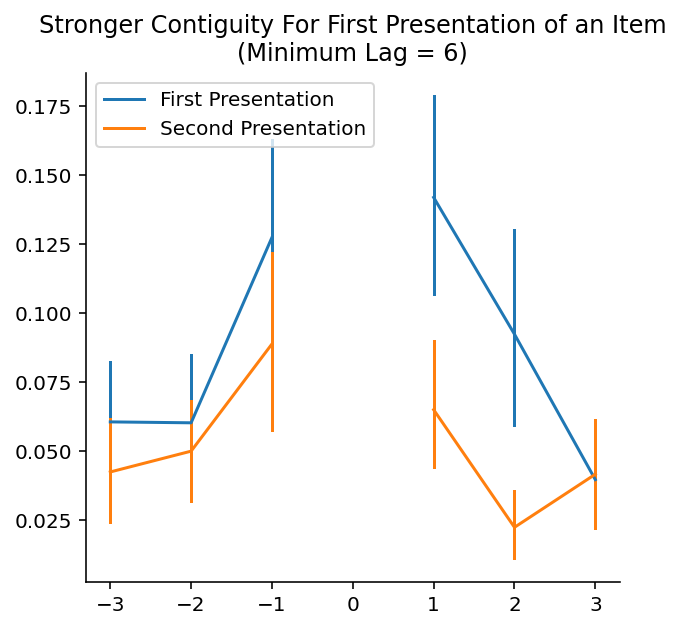

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

max_lag = minimum_lag/2
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

g = sns.FacetGrid(df, height=4.5)
g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_neg), x='lag', y='prob', hue='locus', err_style='bars', **kws)
)

g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_pos), x='lag', y='prob', hue='locus', err_style='bars', **kws)
)

plt.legend(['First Presentation', 'Second Presentation'], loc='upper left')
plt.title('Stronger Contiguity For First Presentation of an Item\n(Minimum Lag = {})'.format(minimum_lag))
plt.tight_layout()

### Control Analysis

In [ ]:
from tqdm import tqdm

individual_results = []

for iteration in tqdm(range(1000)):
    for subject in np.unique(subjects):
        mixed_selection = np.logical_and(list_types == 4, subjects == subject)
        control_selection = np.logical_and(list_types == 1, subjects == subject)
        shuffled_trials = trials[control_selection]
        np.random.shuffle(shuffled_trials)

        individual_results.append(
            alternative_contiguity_control(presentations[mixed_selection], presentations[control_selection], shuffled_trials, minimum_lag))

df = pd.concat(individual_results, keys=np.unique(subjects), names=['subject']).reset_index()
df.drop(['level_2'], axis=1, inplace=True)
df

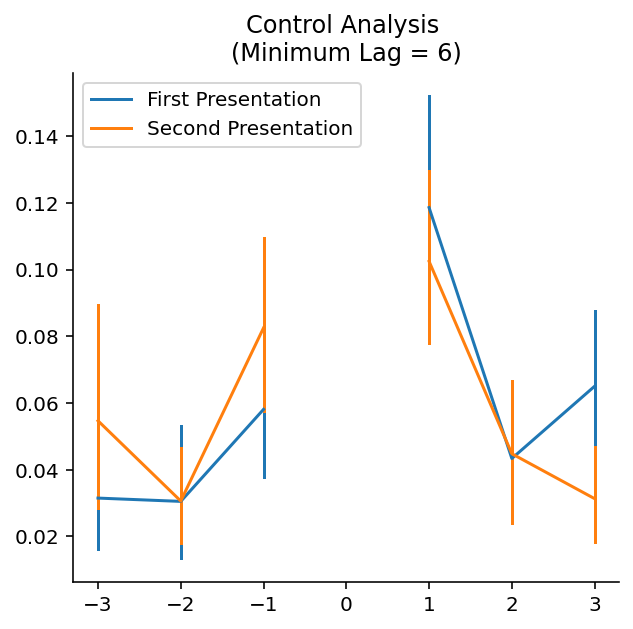

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

max_lag = minimum_lag/2
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

g = sns.FacetGrid(df, height=4.5)
g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_neg), x='lag', y='prob', hue='locus', err_style='bars', **kws)
)

g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_pos), x='lag', y='prob', hue='locus', err_style='bars', **kws)
)

plt.legend(['First Presentation', 'Second Presentation'], loc='upper left')
plt.title('Control Analysis \n(Minimum Lag = {})'.format(minimum_lag))
plt.tight_layout()